[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1D8taxYhrg2QKNE7vRfM_xyn9mYmLi0UU?usp=sharing)

In [ ]:
import gdown
# UIT-VSMEC -  https://nlp.uit.edu.vn/datasets/#h.p_FxJKMfavctsJ
gdown.download_folder('https://drive.google.com/drive/folders/1HooABJyrddVGzll7fgkJ6VzkG_XuWfRu', quiet=True)

['/content/UIT-VSMEC/test_nor_811.xlsx',
 '/content/UIT-VSMEC/train_nor_811.xlsx',
 '/content/UIT-VSMEC/valid_nor_811.xlsx']

In [ ]:
# Install nescessary library
!pip install -q openpyxl emoji transformers torchinfo py_vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.0 MB/s eta 0:00:00


In [ ]:
# Install Java for py_vncorenlp
import os
def install_java():
  !apt-get update -qq
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.21" 2023-10-17
OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
from tqdm import tqdm
import regex as re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [ ]:
train_df = get_data('UIT-VSMEC/train_nor_811.xlsx')
valid_df = get_data('UIT-VSMEC/valid_nor_811.xlsx')
test_df = get_data('UIT-VSMEC/test_nor_811.xlsx')

# Data analytics and preprocessing

In [ ]:
train_df.head()

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


## Dataset info

In [ ]:
print("Train shape = {}".format(train_df.shape))
print("Valid shape = {}".format(valid_df.shape))
print("Test shape = {}".format(test_df.shape))

Train shape = (5548, 2)
Valid shape = (686, 2)
Test shape = (693, 2)


In [ ]:
print("Train dataset infor:")
train_df.info()

print("\nValid dataset infor:")
valid_df.info()

print("\nTest dataset infor:")
test_df.info()

Train dataset infor:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   5548 non-null   object
 1   Sentence  5548 non-null   object
dtypes: object(2)
memory usage: 86.8+ KB

Valid dataset infor:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   686 non-null    object
 1   Sentence  686 non-null    object
dtypes: object(2)
memory usage: 10.8+ KB

Test dataset infor:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


===> Not found missing value

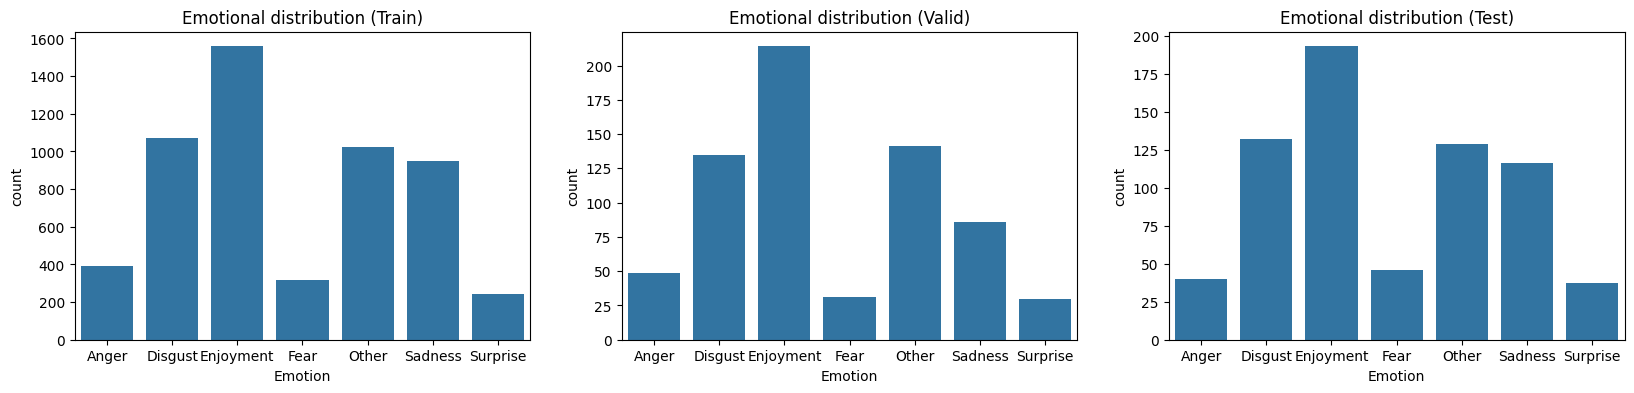

In [ ]:
# Emotional distribution of dataset
emotional_labels = sorted(train_df['Emotion'].unique())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

sns.countplot(x='Emotion', data=train_df, order=emotional_labels, ax=axes[0])
axes[0].set_title('Emotional distribution (Train)')

sns.countplot(x='Emotion', data=valid_df, order=emotional_labels, ax=axes[1])
axes[1].set_title('Emotional distribution (Valid)')

sns.countplot(x='Emotion', data=test_df, order=emotional_labels, ax=axes[2])
axes[2].set_title('Emotional distribution (Test)')

plt.show()

===> Imbalanced dataset -> using ImbalancedDataSampler

## Pre-processing text

Reference: https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb

In [ ]:
# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)

In [ ]:
# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )

In [ ]:
# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

In [ ]:
# Normalize acronyms
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt

replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'ô kê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'cười', 'hehe': 'cười', 'hihi': 'cười', 'haha': 'cười', 'hjhj': 'cười', 'thick': 'thích',
    'huhu': 'khóc', 'cute': 'dễ thương',
    'cc': 'chửi tục', 'cặc':'chửi tục', 'dm':'chửi tục', 'dmm':'chửi tục', 'dume':'chửi tục', 'dma': 'chửi tục', 'vl': 'chửi tục',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',
    'nk': 'nó',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'sốp': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'sgk':'sách giáo khoa', 'cv':'công việc',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'excelent': 'hoàn hảo', 'bt': 'bình thường', 'bth': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '^_^': 'cười', ':)': 'cười',  ':))': 'cười', ':)))': 'cười', '=))': 'cười', '=)))': 'cười', ':(': 'buồn', ':((': 'buồn', ':(((': 'buồn',
    '❤️': 'yêu thích', '👍': 'thích', '🎉': 'chúc mừng', '😀': 'cười', '😍': 'yêu thích', '😂': 'cười lớn', '🤣':'cười lớn', '🤗': 'vỗ tay', '😙': 'cười', '🙂': 'cười',
    '😔': 'buồn', '😓': 'buồn', 'T_T': 'khóc', '😭': 'khóc lớn',  '😡': 'giận dữ', '🤬': 'giận dữ', '🤡': 'mặt chú hề', '😩': 'thất vọng', '😞': 'thất vọng', '😢': 'xúc động',
    '⭐': 'star', '*': 'star', '🌟': 'star',
}

with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
      if word.lower() in replace_list.keys(): words.append(replace_list[word.lower()])
      elif not emoji.is_emoji(word): words.append(word)

    return ' '.join(words)

--2024-02-03 07:43:42--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2024-02-03 07:43:43 (41.1 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [ ]:
import py_vncorenlp
os.makedirs('vncorenlp', exist_ok=True)
py_vncorenlp.download_model(save_dir='/content/vncorenlp')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

# Word segmentation & Tokenize
def word_segmentation(text):
  return rdrsegmenter.word_segment(text)

In [ ]:
def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text)
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ', text) # Remove unnecessary character
    text = re.sub(r'\s+', ' ', text).strip() # Remove spacing > 1
    text = word_segmentation(text) # required for PhoBERT
    text = ' '.join(text) # return 1 string

    return text

In [ ]:
# Test function text_preprocess
rand_idx = np.random.randint(len(train_df), size=5)
for i in range(5):
  print(f"{rand_idx[i]}. Before: {train_df.iloc[rand_idx[i], 1]}")
  print(f"{rand_idx[i]}. After: {text_preprocess(train_df.iloc[rand_idx[i], 1])}")
  print("")

4106. Before: per làm ở đâu không quan trọng , quan trọng là vẫn buôn chuyện đều 😂😂😂
4106. After: per làm ở đâu không quan_trọng quan_trọng là vẫn buôn chuyện đều

2247. Before: thế này lại thành xây nhà cho nhà hàng xóm rồi 😰
2247. After: thế_này lại thành xây nhà cho nhà hàng_xóm rồi

4703. Before: có bài hát " cuộc đời vẫn đẹp sao , tình yêu vẫn đẹp sao "
4703. After: có bài hát cuộc_đời vẫn đẹp sao tình_yêu vẫn đẹp sao

1488. Before: mua thuốc ngoài thú y sức vào vài ngày nó không bám nữa
1488. After: mua thuốc ngoài thú_y sức vào vài ngày nó không bám nữa

3081. Before: per cho vợ đi cầu này để giảm cân nhá 🤣🤣
3081. After: per cho vợ đi_cầu này để giảm cân nhá



# Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from torchinfo import summary

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

In [ ]:
config = {
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'MODEL_NAME': 'PhoBERT-Sentiment',
    'PRETRAINED_NAME': 'vinai/phobert-base-v2',
    'NUM_CLASSES': 7,
    'DROPOUT': 0.5,

    'TRAINING': {
        'N_EPOCHS': 20,
        'INIT_LR': 1e-5,
        'WEIGHT_DECAY': 1e-2,
        'BATCH_SIZE': 8,
        'WORKERS': 0,
        'METRIC_SAVE_BEST': 'f1_score',
        'PATIENCE': 3
    },

    'TOKENIZER': {
      'PADDING': 'max_length',
      'MAX_INPUT_LENGTH': 200,
      'TRUNCATION': True,
      'RETURN_ATTENTION_MASK': True,
      'ADD_SPECIAL_TOKENS': True,
    },
}

label2id = {
  'Anger': 0,
  'Disgust': 1,
  'Enjoyment': 2,
  'Fear': 3,
  'Other': 4,
  'Sadness': 5,
  'Surprise': 6,
}

id2label = {
  0:'Anger',
  1:'Disgust',
  2:'Enjoyment',
  3:'Fear',
  4:'Other',
  5:'Sadness',
  6:'Surprise',
}

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, config):
        self.df = df
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=self.config['TRUNCATION'],
            add_special_tokens=self.config['ADD_SPECIAL_TOKENS'],
            max_length=self.config['MAX_INPUT_LENGTH'],
            padding=self.config['PADDING'],
            return_attention_mask=self.config['RETURN_ATTENTION_MASK'],
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        text = row['Sentence']
        text = text_preprocess(text)
        label = label2id[row['Emotion']]

        return text, label

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        row = dataset.df.iloc[idx]
        return label2id[row['Emotion']]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, config):
        super(SentimentClassifier, self).__init__()
        self.basemodel = AutoModel.from_pretrained(config['PRETRAINED_NAME'])
        self.drop1 = nn.Dropout(p=config['DROPOUT'])
        self.fc1 = nn.Linear(self.basemodel.config.hidden_size, 256)
        self.drop2 = nn.Dropout(p=config['DROPOUT'])
        self.fc2 = nn.Linear(256, config['NUM_CLASSES'])

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.basemodel(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        x = self.drop1(output)
        x = self.fc1(x)
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [ ]:
class Task():
  def __init__(self, config):
    self.config = config
    self.save_path = os.path.join('/content/drive/MyDrive',config['MODEL_NAME'])
    self.device = config['DEVICE']

    self.num_epochs = config['TRAINING']['N_EPOCHS']
    self.patience = config['TRAINING']['PATIENCE']
    self.best_metric= config['TRAINING']['METRIC_SAVE_BEST']
    self.learning_rate = config['TRAINING']['INIT_LR']
    self.weight_decay = config['TRAINING']['WEIGHT_DECAY']
    self.batch_size = config['TRAINING']['BATCH_SIZE']
    self.num_workers = config['TRAINING']['WORKERS']

    self.tokenizer = AutoTokenizer.from_pretrained(config['PRETRAINED_NAME'])
    self.model = SentimentClassifier(config).to(self.device)

    # Create Dataloader
    trainDataset = SentimentDataset(train_df, self.tokenizer, config['TOKENIZER'])
    validDataset = SentimentDataset(valid_df, self.tokenizer, config['TOKENIZER'])
    testDataset = SentimentDataset(test_df, self.tokenizer, config['TOKENIZER'])
    self.train_loader = DataLoader(trainDataset, batch_size=self.batch_size, num_workers=self.num_workers, sampler=ImbalancedDatasetSampler(trainDataset))
    self.valid_loader = DataLoader(validDataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)
    self.test_loader = DataLoader(testDataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    # Create optimizer & scheduler
    self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
    #self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=self.learning_rate*5, steps_per_epoch=len(self.train_loader), epochs=self.num_epochs)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=1, threshold=0.001, threshold_mode='abs')
    # Create criterion
    self.criterion = nn.CrossEntropyLoss()

  def print_summary(self):
    sample = next(iter(self.train_loader))
    input_ids = sample['input_ids'].to(self.device)
    attention_masks = sample['attention_masks'].to(self.device)
    print(summary(self.model, input_data=[input_ids, attention_masks], dtypes=[torch.int64]))

  def training(self):
    if not os.path.exists(self.save_path):
      os.makedirs(self.save_path)

    if os.path.exists(os.path.join(self.save_path, 'last_model.pth')):
      checkpoint = torch.load(os.path.join(self.save_path, 'last_model.pth'))
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      initial_epoch = checkpoint['epoch'] + 1
      print(f"Continue training from epoch {initial_epoch}")
    else:
      initial_epoch = 0
      print("First time training!!!")

    if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
        checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'))
        best_score = checkpoint['score']
        print(f"Current best score: {best_score}")
    else:
        best_score = 0.

    threshold = 0
    self.model.train()
    for epoch in range(initial_epoch, self.num_epochs + initial_epoch):
      # Train
      correct = 0
      all_preds = []
      all_targets = []
      train_loss = 0.
      with tqdm(desc=f'Epoch {epoch + 1:2d} - Training  ', unit='it', total=len(self.train_loader)) as pbar:
        for it, data in enumerate(self.train_loader):
          input_ids = data['input_ids'].to(self.device)
          attention_masks = data['attention_masks'].to(self.device)
          targets = data['targets'].to(self.device)
          self.optimizer.zero_grad()
          outputs = self.model(input_ids, attention_masks)
          loss = self.criterion(outputs, targets)
          _, pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred == targets)
          train_loss += loss
          loss.backward()
          self.optimizer.step()

          cur_loss = train_loss.detach().cpu().numpy() / (it + 1)
          all_preds.extend(pred.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())
          pbar.set_postfix({'loss': f"{cur_loss:.4f}", 'lr':self.optimizer.param_groups[0]['lr']})
          pbar.update()

      train_loss /= len(self.train_loader)
      acc_train = correct.double() / len(self.train_loader.dataset)
      f1_train = f1_score(all_targets, all_preds, average='weighted')

      # Valid
      correct = 0
      all_preds = []
      all_targets = []
      valid_loss = 0.
      self.model.eval()
      with tqdm(desc=f'Epoch {epoch + 1:2d} - Evaluation', unit='it', total=len(self.valid_loader)) as pbar:
        for it, data in enumerate(self.valid_loader):
          input_ids = data['input_ids'].to(self.device)
          attention_masks = data['attention_masks'].to(self.device)
          targets = data['targets'].to(self.device)
          with torch.no_grad():
            outputs = self.model(input_ids, attention_masks)
          loss = self.criterion(outputs, targets)
          _, pred = torch.max(outputs, dim=1)

          correct += torch.sum(pred == targets)
          valid_loss += loss
          all_preds.extend(pred.cpu().numpy())
          all_targets.extend(targets.cpu().numpy())
          pbar.update()

      valid_loss /= len(self.valid_loader)
      acc_valid = correct.double() / len(self.valid_loader.dataset)
      f1_valid = f1_score(all_targets, all_preds, average='weighted')
      content = f"Epoch {epoch + 1:2d} - Train loss: {train_loss:.4f} - acc: {acc_train:.4f} - f1: {f1_train:.4f} - Valid loss: {valid_loss:.4f} - val_acc: {acc_valid:.4f} - val_f1: {f1_valid:.4f} - lr: {self.optimizer.param_groups[0]['lr']:1.2e}\n"
      self.scheduler.step(valid_loss)
      print(content)
      with open(os.path.join(self.save_path, 'log.txt'), 'a') as file:
        file.write(content)

      if self.best_metric =="f1_score":
        score = f1_valid
      else:
        score = acc_valid

      # Save the last model
      torch.save({
          'epoch': epoch,
          'model_state_dict': self.model.state_dict(),
          'optimizer_state_dict': self.optimizer.state_dict(),
          'score': score}, os.path.join(self.save_path, 'last_model.pth'))

      if epoch > 0 and score <= best_score:
        threshold += 1
      else:
        threshold = 0

      # Save the best model
      if score > best_score:
        best_score = score
        shutil.copyfile(os.path.join(self.save_path, 'last_model.pth'), os.path.join(self.save_path, 'best_model.pth'))

      # early stopping
      if threshold >= self.patience:
          print(f"Early stopping after epoch {epoch + 1}")
          break


  def get_predict(self):
    # Load the model
    print("Loadding best model...")
    if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
      checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'))
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.model.eval()
    else:
      print("Prediction require the model must be trained. There is no weights to load for model prediction!")
      raise FileNotFoundError("Make sure your checkpoint path is correct or the best_model.pth is available in your checkpoint path")
    clean_texts = []
    predicts = []
    targets = []

    with tqdm(desc='Predicting', unit='it', total=len(self.test_loader)) as pbar:
      for it, data in enumerate(self.test_loader):
        text = data['text']
        input_ids = data['input_ids'].to(self.device)
        attention_masks = data['attention_masks'].to(self.device)
        data_targets = data['targets'].to(self.device)

        with torch.no_grad():
          outputs = self.model(input_ids, attention_masks)

        _, pred = torch.max(outputs, dim=1)
        clean_texts.extend(text)
        predicts.extend(pred)
        targets.extend(data_targets)
        pbar.update()

    predicts = torch.stack(predicts).cpu().tolist()
    targets = torch.stack(targets).cpu()

    result_df = test_df.copy()
    result_df['clean_text'] = clean_texts
    result_df['predicts'] = [ id2label[p] for p in predicts ]

    result_df.to_excel(os.path.join(self.save_path, 'test_result.xlsx'), sheet_name='Result', index=False)
    print(f"Save test result to: {os.path.join(self.save_path, 'test_result.xlsx')}")

    return targets, predicts


In [ ]:
task = Task(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
task.print_summary()

Layer (type:depth-idx)                                       Output Shape              Param #
SentimentClassifier                                          [8, 7]                    --
├─RobertaModel: 1-1                                          [8, 200, 768]             --
│    └─RobertaEmbeddings: 2-1                                [8, 200, 768]             --
│    │    └─Embedding: 3-1                                   [8, 200, 768]             49,152,768
│    │    └─Embedding: 3-2                                   [8, 200, 768]             768
│    │    └─Embedding: 3-3                                   [8, 200, 768]             198,144
│    │    └─LayerNorm: 3-4                                   [8, 200, 768]             1,536
│    │    └─Dropout: 3-5                                     [8, 200, 768]             --
│    └─RobertaEncoder: 2-2                                   [8, 200, 768]             --
│    │    └─ModuleList: 3-6                                  --               

In [ ]:
task.training()

Continue training from epoch 12
Current best score: 0.6284379820315755


Epoch 13 - Evaluation: 100%|██████████| 86/86 [00:07<00:00, 11.69it/s]


Epoch 13 - Train loss: 0.3175 - acc: 0.9061 - f1: 0.9075 - Valid loss: 1.2549 - val_acc: 0.6239 - val_f1: 0.6229 - lr: 1.00e-08



Epoch 14 - Evaluation: 100%|██████████| 86/86 [00:07<00:00, 11.57it/s]


Epoch 14 - Train loss: 0.1068 - acc: 0.9778 - f1: 0.9778 - Valid loss: 1.2550 - val_acc: 0.6239 - val_f1: 0.6231 - lr: 1.00e-08



Epoch 15 - Evaluation: 100%|██████████| 86/86 [00:07<00:00, 11.44it/s]


Epoch 15 - Train loss: 0.0905 - acc: 0.9847 - f1: 0.9847 - Valid loss: 1.2551 - val_acc: 0.6254 - val_f1: 0.6244 - lr: 1.00e-08

Early stopping after epoch 15


In [ ]:
targets, predicts = task.get_predict()

Loadding best model...


Predicting: 100%|██████████| 87/87 [00:06<00:00, 12.92it/s]


Save test result to: /content/drive/MyDrive/PhoBERT-Sentiment/test_result.xlsx


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
print(f"F1 score: {f1_score(targets, predicts, average='weighted'):.4f}")
print(f"Accuracy: {accuracy_score(targets, predicts):.4f}")

F1 score: 0.6396
Accuracy: 0.6407


In [ ]:
print("\nClassification Report")
class_names = ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise']
print(classification_report(targets, predicts, target_names=class_names))


Classification Report
              precision    recall  f1-score   support

       Anger       0.56      0.35      0.43        40
     Disgust       0.57      0.70      0.63       132
   Enjoyment       0.72      0.71      0.72       193
        Fear       0.67      0.72      0.69        46
       Other       0.52      0.58      0.55       129
     Sadness       0.75      0.66      0.71       116
    Surprise       0.76      0.43      0.55        37

    accuracy                           0.64       693
   macro avg       0.65      0.59      0.61       693
weighted avg       0.65      0.64      0.64       693



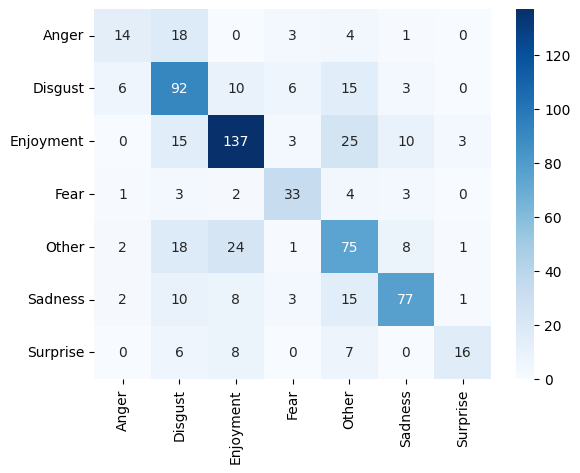

In [ ]:
sns.heatmap(confusion_matrix(targets, predicts), annot=True, fmt='d', cmap="Blues", xticklabels = class_names, yticklabels = class_names);

In [ ]:
torch.save(task.model.state_dict(), os.path.join(task.save_path, 'sentiment-model.pth'))